In [101]:
# Importing the libraries that I will use
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import plot_tree

# Read in track metadata with genre labels
tracks = pd.read_csv('/home/jovyan/work/release/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('/home/jovyan/work/release/echonest-metrics.json', precise_float = True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], on = 'track_id')

# Inspect the resultant dataframe
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [79]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


In [80]:
# Create features
features = echo_tracks.drop(columns = ['genre_top', 'track_id'])

# Create labels
labels = echo_tracks['genre_top']

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 10)

In [82]:
# Running an initial Decision Tree model
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

class_rep_tree = classification_report(test_labels, pred_labels_tree)

print("Decision Tree: \n", class_rep_tree)


Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.66      0.68      0.67       235
        Rock       0.92      0.92      0.92       966

    accuracy                           0.87      1201
   macro avg       0.79      0.80      0.79      1201
weighted avg       0.87      0.87      0.87      1201



In [38]:
# Normalizing the features so that the mean = 1 and standard_deviation = 1
# This is so we can improve the Decision Tree model by using principal component analysis (PCA)
# Which optimizes the model by reducing the number of features so that it is most accuarate
scaler = StandardScaler()

scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.fit_transform(test_features)

Text(0.5, 0, 'Principal Component #')

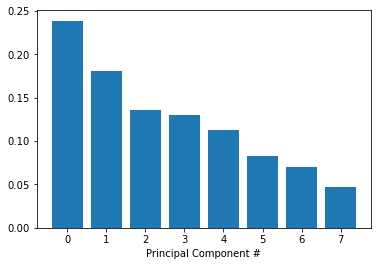

In [39]:
# Make plots appear in notebook
%matplotlib inline

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

Text(0.5, 0, '# of Features')

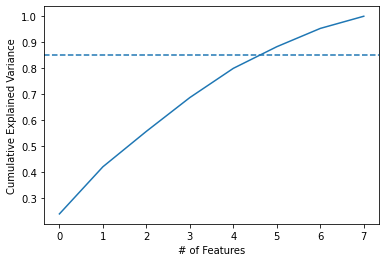

In [56]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_xlabel('# of Features')

In [57]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components = 6, random_state = 10)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.fit_transform(scaled_test_features)

In [85]:
# Train our decision tree
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

In [86]:
# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.66      0.68      0.67       235
        Rock       0.92      0.92      0.92       966

    accuracy                           0.87      1201
   macro avg       0.79      0.80      0.79      1201
weighted avg       0.87      0.87      0.87      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.56      0.66       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.89      1201
   macro avg       0.85      0.76      0.79      1201
weighted avg       0.88      0.89      0.88      1201



In [61]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.85      0.83       230
        Rock       0.84      0.79      0.81       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.85      0.82      0.84       230
        Rock       0.82      0.85      0.84       225

    accuracy                           0.84       455
   macro avg       0.84      0.84      0.84       455
weighted avg       0.84      0.84      0.84       455



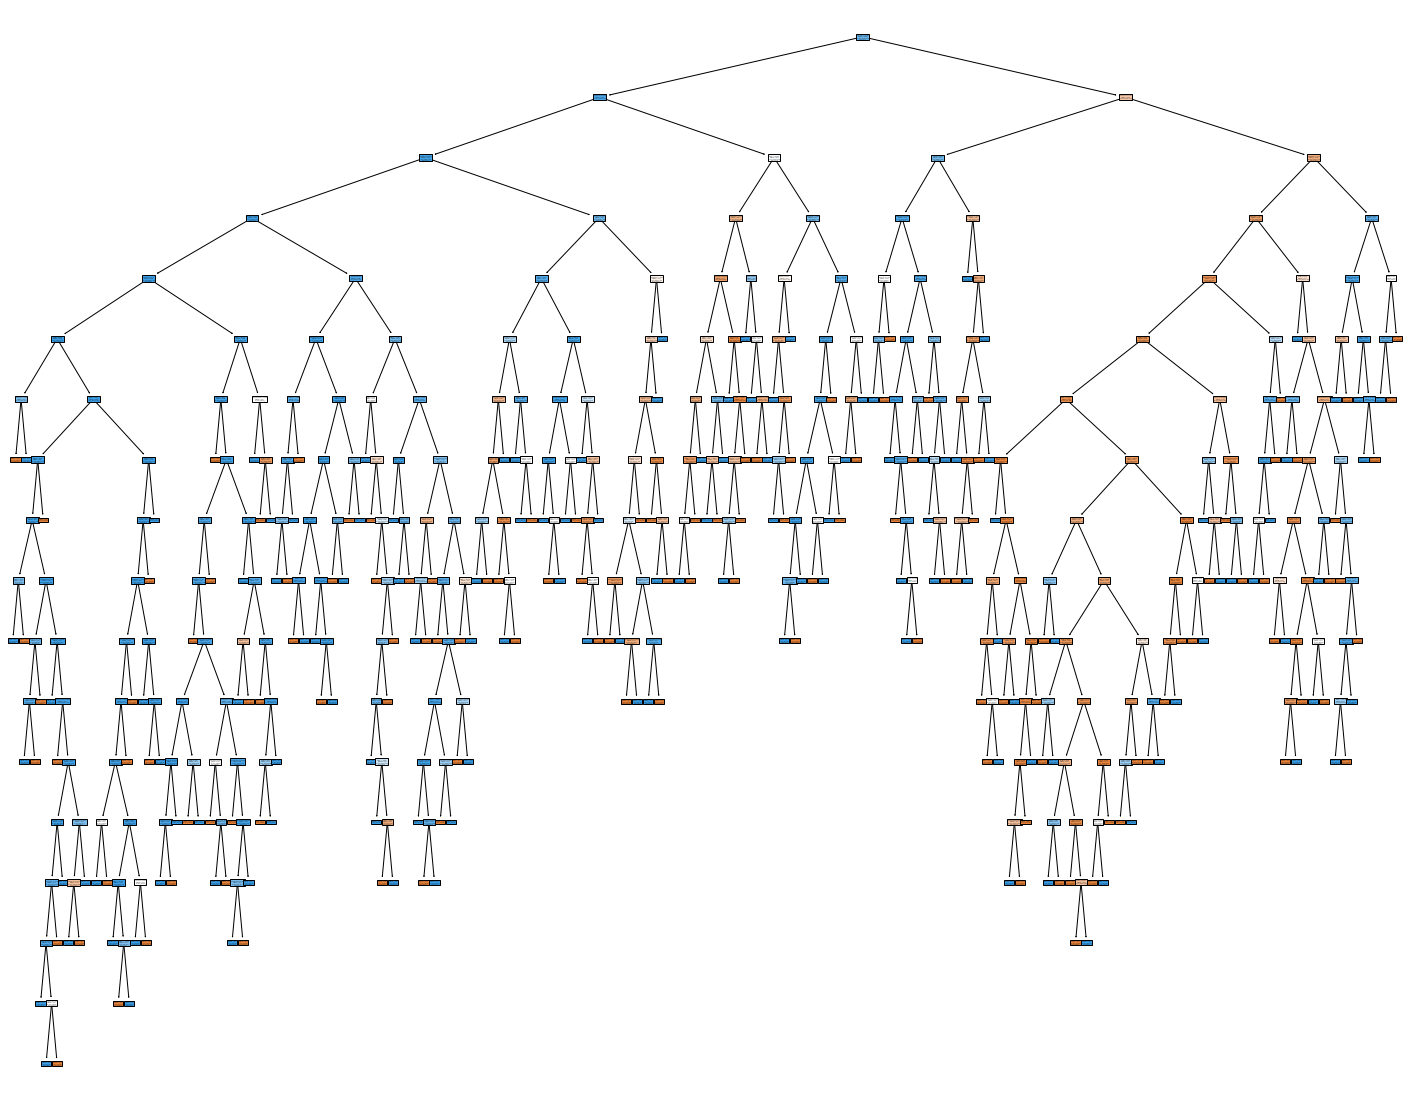

In [108]:
fig = plt.figure(figsize = (25,20))
plot_tree(tree,
         feature_names = train_features.columns,
         class_names =['Hip-Hop', 'Rock'],
         impurity = False,
         proportion = True,
         filled = True)

fig.savefig('song_genre_tree.png')


In [88]:
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])

# Set up our K-fold cross-validation
kf = KFold(n_splits = 10, random_state = 10)

# Train our models using KFold cv
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.8442182085932085 Logistic Regression: 0.8660624566874567


In [ ]:
# Below here I will test out Adaboost and Gradient boost methods

In [89]:
# Creating Ada Boost model with 100 leaners
clf = AdaBoostClassifier(n_estimators = 100)
clf.fit(train_features, train_labels)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [90]:
# Testing different n_estimator levels
# I want to see if there is a number of estimators that is best
 
train_scores = [p for p in clf.staged_score(train_features, train_labels)]
test_scores = [p for p in clf.staged_score(test_features, test_labels)]




Best number of learners are : 82
Highest accurary : 0.9175686927560366


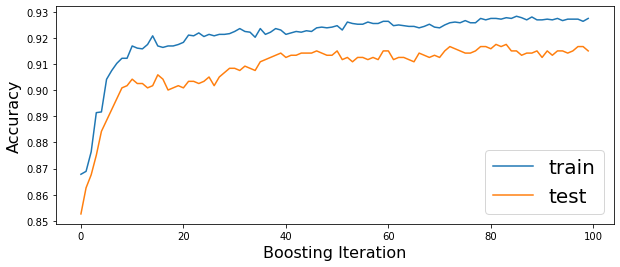

In [96]:
number_estimators = range(1, 101)

#matplotlib.pyplot.plot(number_estimators, train_scores)
#matplotlib.pyplot.plot(number_estimators, test_scores)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))
ax.plot(train_scores, label = "train")
ax.plot(test_scores, label = "test")
ax.legend(loc = "bottom right", fontsize = 20)
ax.set_xlabel("Boosting Iteration", fontsize = 16)
ax.set_ylabel("Accuracy", fontsize = 16)
print("Best number of learners are :", best_leaners)
print("Highest accurary :", max(test_scores))


In [95]:
# Getting the value of the max value
max_score = max(test_scores)

# Getting the index of the max value
# The index is 46 therefore the highest accuracy is with 47 estimators
best_leaners = test_scores.index(max_score) + 1

print("Best number of learners are :", best_leaners)
print("Highest accurary :", max(test_scores))

# Recreating the model wit hthe best number of learners
clf = AdaBoostClassifier(n_estimators = best_leaners)
clf.fit(train_features, train_labels)
pred_labels_clf = clf.predict(test_features)


Best number of learners are : 82
Highest accurary : 0.9175686927560366


In [93]:
print("Ada Boost: \n", classification_report(test_labels, pred_labels_clf))
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Ada Boost: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.74      0.78       235
        Rock       0.94      0.96      0.95       966

    accuracy                           0.92      1201
   macro avg       0.88      0.85      0.86      1201
weighted avg       0.92      0.92      0.92      1201

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.66      0.68      0.67       235
        Rock       0.92      0.92      0.92       966

    accuracy                           0.87      1201
   macro avg       0.79      0.80      0.79      1201
weighted avg       0.87      0.87      0.87      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.56      0.66       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.89      1201
   macro avg       0.85      0.76      0.79      1201
weighted avg       0.